## Model trained on 2 min resolution data

In [7]:
from keras.models import Sequential
from keras.layers import Conv1D,Input,Dense,Flatten
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [272]:
sample_length = 32 # approximately corresponding to 1 hour

In [69]:
aggregate_power = pd.read_csv('../master_data/house_1/channel_1.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')
#mw_activations = pd.read_csv('../master_data/nilm/mw_activations.dat', #header = None,
#                                delim_whitespace = True,
#                                names = ['index', 'start','end','mean_power'],
#                                index_col = 0)
kettle_activations = pd.read_csv('../master_data/nilm/kettle_activations.dat', header = 0,
                                delim_whitespace = True,
                                names = ['index', 'start','end','mean_power'],
                                index_col = 0, parse_dates = ['start','end'],
                                date_parser = pd.core.tools.datetimes.to_datetime)
#dw_activations = pd.read_csv('../master_data/nilm/dw_activations.dat', #header = None,
#                                delim_whitespace = True,
#                                names = ['index', 'start','end','mean_power'],
#                                index_col = 0)
kettle_activations.head()

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start,end,mean_power
index,,,
0,2012-11-10 08:49:42,2012-11-10 08:51:45,2311.157895
1,2012-11-10 17:22:40,2012-11-10 17:24:05,2282.692308
2,2012-11-11 08:28:41,2012-11-11 08:30:47,2261.200000
3,2012-11-11 11:35:09,2012-11-11 11:38:09,2282.896552
4,2012-11-11 11:44:35,2012-11-11 11:46:59,2285.956522


2012-11-15 07:49:53 2012-11-15 07:52:02


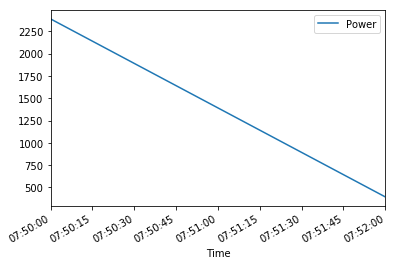

In [193]:
for _ in range(1):
    dice = np.random.randint(0,100)
    start = kettle_activations.iloc[dice]['start']
    end = kettle_activations.iloc[dice]['end']
    print(start,end)
    aggregate_power_2m[start:end].plot()
    plt.show()

In [429]:
(kettle_activations['end'] - kettle_activations['start']).sort_values().tail(10)

index
1133   00:06:22
1566   00:06:26
355    00:06:28
1063   00:07:16
1193   00:07:17
2344   00:07:49
1490   00:07:54
1221   00:07:58
1119   00:08:57
3092   00:11:25
dtype: timedelta64[ns]

#### Note:
The minimal run time of the kettle is 30 seconds.

In [216]:
durations = (kettle_activations['end'] - kettle_activations['start'])
print(durations.where(durations > pd.Timedelta('2min')).isnull().value_counts()[0]/durations.shape[0],
      "of the activations exceed 2 minutes.")

0.480475899939 of the activations exceed 2 minutes.


It is not entirely clear to me how the authors of the paper created their training sets (only that they extended them substantially with syntethic data). Below is an attempt to create a training set in the spirit of the paper, by randomly selecting "empty" and "meaningful" intervals with a 50/50 probability.

In [271]:
def clean_power_series(aggregate_power, activations):
    
    temp_ap = aggregate_power.copy()
    
    n = activations.shape[0]

    #pcent = int(n/100)
    ap_sans_activations = pd.DataFrame()
    
    ap_sans_activations.append(temp_ap[:activations['start'][0]])
    
    for i in range(1,n):
        ap_sans_activations = ap_sans_activations.append(temp_ap[activations['end'][i-1]:activations['start'][i]])
    
    ap_sans_activations.append(temp_ap[activations['end'][i]:])
    
    return ap_sans_activations


def create_training_set(aggregate_power, activations, ap_sans_activations = None, sample_length = 128, pad = 1024):
    training_set = pd.DataFrame(columns = np.linspace(0,1,sample_length))
    training_set_response = pd.DataFrame(columns = ['start','end','mean_power'])

    #aggregate power sans the activation intervals
    if ap_sans_activations is None:
        ap_sans_activations = clean_power_series(aggregate_power,activations)

    n = aggregate_power.shape[0]
    j = 0
    for i in range(activations.shape[0]):
        if i % 100 == 0:
            print(i)
        while True:
            dice = np.random.random()
            if dice < 0.5:
                start = activations['start'][i]
                end = activations['end'][i]
                #randomly place the chosen signal in a window.
                #note that the entire signal is always in the window 
                sample_start = start - pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample_end = end + pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample = aggregate_power[sample_start:sample_end]

                while sample.shape[0] > sample_length:
                    if np.random.random() > 0.5 and end + pd.timeDelta('15min') < sample.index[-1]:
                        sample = sample.iloc[:-1]
                    elif start - pd.timeDelta('15min') > sample.index[0]:
                        sample = sample.iloc[1:]
                    else:
                        sample = sample.iloc[0:1]
                
                if not sample.shape[0] < sample_length:
                    
                    #sample = sample.reindex(columns=training_set.columns, method='nearest')
                    start_fraction = (start - sample.index[0])/(sample.index[-1] - sample.index[0])
                    end_fraction = (end - sample.index[0])/(sample.index[-1] - sample.index[0])
                    training_set.loc[j] = sample.T.values[0]
                    training_set_response.loc[j] = [start_fraction,end_fraction,activations['mean_power'][i]]
                    j+=1
                
                break
                
                
            ri = np.random.randint(0,ap_sans_activations.shape[0]-sample_length)
            sample = ap_sans_activations.iloc[ri: ri+sample_length]
            training_set.loc[j] = sample.T.values[0]
            training_set_response.loc[j] = [0,0,0]
            j+=1
            
    return training_set, training_set_response



In [295]:
#aggregate_power.resample('2min').mean().isnull()['Power'].value_counts()
aggregate_power_15m = aggregate_power.resample('15min').mean()
aggregate_power_15m = aggregate_power_15m.dropna()
print(aggregate_power.shape, aggregate_power_15m.shape)

(10239433, 1) (71323, 1)


#### Note: 
drop() takes forever, avoid it.<br>


In [296]:
clean_ap = clean_power_series(aggregate_power_15m,kettle_activations)

In [376]:
training_set_kettle, response_kettle = create_training_set(aggregate_power_15m, kettle_activations,
                                                           ap_sans_activations = clean_ap,
                                                          sample_length = sample_length, pad = 200000)
training_set_kettle.head()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


,0.0,0.0322580645161,0.0645161290323,0.0967741935484,0.129032258065,0.161290322581,0.193548387097,0.225806451613,0.258064516129,0.290322580645,...,0.709677419355,0.741935483871,0.774193548387,0.806451612903,0.838709677419,0.870967741935,0.903225806452,0.935483870968,0.967741935484,1.0
0,137.480916,137.932331,147.180451,193.520000,577.650794,284.258993,205.827068,419.733333,668.442748,250.688889,...,494.423077,214.548872,185.575758,144.187500,299.272059,569.828358,581.596899,412.081481,218.776923,226.037037
1,409.263514,1508.438849,457.966216,173.147651,222.695946,251.217687,214.324324,208.156463,219.694444,187.101351,...,212.517007,210.333333,155.108844,168.246575,285.087838,183.621622,212.911565,210.346939,214.351351,197.864865
2,419.733333,668.442748,250.688889,1303.362205,2225.727273,1058.601562,905.971014,856.209677,570.423358,1095.421053,...,412.081481,218.776923,226.037037,872.503759,508.207692,555.674242,1011.069231,636.688000,979.900000,812.692913
3,207.233083,212.063492,163.030075,152.945312,153.318519,185.000000,275.774436,235.387597,194.616000,201.480916,...,292.870229,218.902256,212.431818,204.871212,165.587786,165.932331,205.187500,165.154472,164.684615,698.045802
4,275.774436,235.387597,194.616000,201.480916,181.307692,200.907692,153.733333,153.829630,167.872000,790.666667,...,205.187500,165.154472,164.684615,698.045802,677.030769,791.354331,324.484615,208.977612,181.552239,191.835714


In [401]:
response_kettle.where(response_kettle['mean_power'] == 0).dropna().shape

(3353, 3)

### Normalization:

As per the paper, done by subtracting sample mean and dividing by a <i>random</i> sample standard deviation.<br>
The normalization parameters are saved so they may be used when testing the model.

start            1.026559
end              1.030968
mean_power    2323.315789
Name: 383, dtype: float64


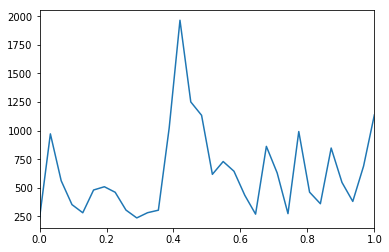

In [414]:
for _ in range(1):
    dice = np.random.randint(0,1000)
    training_set_kettle.iloc[dice].plot()
    print(response_kettle.iloc[dice])
    plt.show()

In [415]:
syntethic_data = pd.read_csv('../master_data/nilm/syntethic_data_15m.dat',
                                delim_whitespace = True,
                                index_col = 0)

syntethic_response = pd.read_csv('../master_data/nilm/syntethic_response_15m.dat', header = 0,
                                names = ["Time","start","end","mean_power"], delim_whitespace = True,
                                index_col = 0)

#syntethic_training_set.columns = pd.to_numeric(syntethic_data.columns)
syntethic_response.head()

,start,end,mean_power
Time,,,
0,0.000000,0.000000,0.000000
1,0.225806,0.225806,NaN
2,0.225806,0.225806,NaN
3,0.322581,0.354839,365.619718
4,0.000000,0.000000,0.000000


In [416]:
#real_data = pd.concat([training_set_kettle,response_kettle],axis=1)

col_dict = dict(zip(syntethic_data.columns.values,training_set_kettle.columns.values))
X = training_set_kettle.append(syntethic_data.rename(columns=col_dict))

y = response_kettle.append(syntethic_response)

print(X.shape)
print(y.shape)

X_np = np.array(X,dtype=np.float64).reshape((X.shape[0],X.shape[1],1))
y_np = np.array(y,dtype=np.float64).reshape((y.shape[0],y.shape[1]))

#some cleaning (some of the syntethic data contained 0-length signals?)
dirty = []
for i in range(y_np.shape[0]):
    if np.isnan(y_np[i]).any():
        dirty.append(i)
y_np = np.delete(y_np, dirty,axis=0)
X_np = np.delete(X_np, dirty,axis=0)

print("Removed " + str(len(dirty)) + " instances.")
#row_mean = syntethic_data.mean(axis=1)
#syntethic_data_n = syntethic_data.sub(row_mean.T,axis=0)
#rand_sd = syntethic_data.std(axis=1)
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
#syntethic_data_n = syntethic_data_n.div(rand_sd,axis=0)
#syntethic_data_n.head()



(15363, 32)
(15363, 3)
Removed 4324 instances.


(5791, 96)

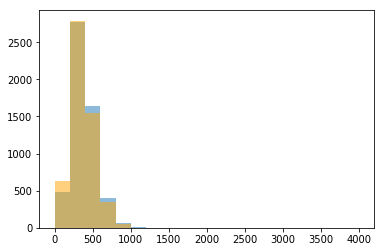

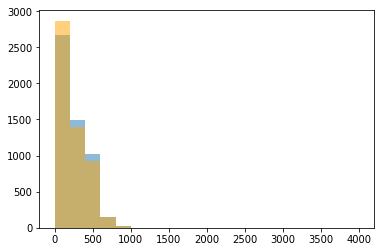

In [417]:
#Tangent: The syntethic data looks a lot like the real data
means_real = training_set_kettle.mean(axis=1).sort_values().reset_index(drop=True)
means_synth = syntethic_data[:means_real.size].mean(axis=1).sort_values().reset_index(drop=True)
plt.hist(means_real,alpha=0.5, bins=20, range=(0,4000))
plt.hist(means_synth,alpha=0.5,color='orange', bins=20, range=(0,4000))
plt.show()

stds_real = training_set_kettle.std(axis=1).sort_values().reset_index(drop=True)
stds_synth = syntethic_data[:stds_real.size].std(axis=1).sort_values().reset_index(drop=True)
plt.hist(stds_real,alpha=0.5,bins=20, range=(0,4000))
plt.hist(stds_synth,alpha=0.5,color='orange',bins=20, range=(0,4000))
plt.show()

In [418]:
mean = X_np.mean(axis=1).reshape(X_np.shape[0],1,1)
#mean = 0.0
X_np = X_np - mean
sd = X_np.std(axis=1).mean()
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X_np /= sd
print("Mean: ", X_np.mean())
print("Std: ", X_np.std())


Mean:  -9.13169500761e-19
Std:  1.21589761696


In [419]:

normalization_params = pd.DataFrame([[mean,sd]],columns=['mean','sd'])
normalization_params.to_csv('../master_data/nilm/normalization_params.csv',sep=' ')

In [420]:
#Experiment: Resize the time intervals from the [0,1] range to [0,1000]
y_np[:,0] = y_np[:,0]*1000
y_np[:,1] = y_np[:,1]*1000
y_np[:,1]

array([  143.5483871 ,     0.        ,  1019.53405018, ...,     0.        ,
           0.        ,     0.        ])

In [105]:
#data = pd.concat([training_set_kettle,response_kettle],axis=1)
#data = data.sample(frac=1).reset_index(drop=True)

#split = int(data.shape[0]*0.5)
#training_set = data[:split]
#test_set = data[split:]

#syntethic_training_set = pd.concat([syntethic_data,syntethic_response],axis=1)
#col_dict = dict(zip(syntethic_training_set.columns.values,training_set.columns.values))
#training_set = training_set.append(syntethic_training_set.rename(columns=col_dict))
#print(training_set.shape)
#X_train = training_set.iloc[:,:-3]
#y_train = training_set.iloc[:,-3:]

#X_test = test_set.iloc[:,:-3]
#y_test = test_set.iloc[:,-3:]

#X_train_np = np.array(X_train,dtype=np.float64).reshape((X_train.shape[0],X_train.shape[1],1))
#y_train_np = np.array(y_train,dtype=np.float64).reshape((y_train.shape[0],y_train.shape[1]))

#X_test_np = np.array(X_test,dtype=np.float64).reshape((X_test.shape[0],X_test.shape[1],1))
#y_test_np = np.array(y_test,dtype=np.float64).reshape((y_test.shape[0],y_test.shape[1]))

#some cleaning (some of the syntethic data contained 0-length signals?)
#dirty_train = []
#for i in range(y_train_np.shape[0]):
#    if np.isnan(y_train_np[i]).any():
#        dirty_train.append(i)
#y_train_np = np.delete(y_train_np, dirty_train,axis=0)
#X_train_np = np.delete(X_train_np, dirty_train,axis=0)

#dirty_test = []
#for i in range(y_test_np.shape[0]):
#    if np.isnan(y_test_np[i]).any():
#        dirty_test.append(i)
#y_test_np = np.delete(y_test_np, dirty_test,axis=0)
#X_test_np = np.delete(X_test_np, dirty_test,axis=0)



(12813, 131)


In [421]:
#Tensorflow uses shape [samples][height][width][channels] 

layer1 = Conv1D(filters=16, input_shape = (sample_length,1,),kernel_size=4,
                activation='linear',padding='valid', strides=1)
layer2 = Conv1D(filters=16, kernel_size=4,activation='linear',padding='valid', strides=1)
layer2_b = Flatten()
layer3 = Dense(units=4096,activation='relu')
layer4 = Dense(units=3072,activation='relu')
layer5 = Dense(units=2048,activation='relu')
layer6 = Dense(units=512,activation='relu')
outputs = Dense(units=3,activation='linear')

model = Sequential()

model.add(layer1)
model.add(layer2)
model.add(layer2_b)
model.add(layer3)
model.add(layer4)
model.add(layer5)
model.add(layer6)
model.add(outputs)

In [427]:

print(X_np.shape, y_np.shape)
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mae'])

training_history = model.fit(X_np, y_np, batch_size=64,verbose=1,epochs=2, validation_split=0.5)

(11039, 32, 1) (11039, 3)
Train on 5519 samples, validate on 5520 samples
Epoch 1/2
5519/5519 [==============================] - 48s 9ms/step - loss: 405454.9325 - mean_absolute_error: 431.1595 - val_loss: 436210.0035 - val_mean_absolute_error: 446.8267
Epoch 2/2
5519/5519 [==============================] - 48s 9ms/step - loss: 386346.9559 - mean_absolute_error: 418.8524 - val_loss: 300814.5062 - val_mean_absolute_error: 365.1828


In [425]:
model.save('../master_data/nilm/models/model0122ds15.h5')

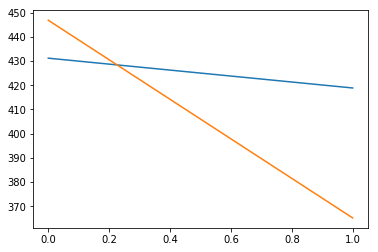

In [428]:
plt.plot(training_history.history['mean_absolute_error'])
plt.plot(training_history.history['val_mean_absolute_error'])
plt.show()